# Practical Lab 3 - Training a CNN for a real-world Image Classification

## Student Information

| Field         | Details                                    |
|---------------|--------------------------------------------|
| **Name**      | Christo Pananjickal Baby                   |
| **Student ID**| 8989796                                    |
| **Email**     | cpananjickalbab9796@conestogac.on.ca       |

---

## Introduction

In this assignment, we will take a practical approach used by deep learning engineers: start with an existing model that performs a similar task and **fine-tune it** for our specific classification problem — identifying dogs vs. cats in images.

The key steps involved are:

1. **Obtain the Data**
   Use a subset of the Dogs vs Cats dataset (5,000 images total) for training and evaluation.

2. **Exploratory Data Analysis (EDA)**
   Explore the image data using visualizations and statistical summaries to understand class distribution, image properties, and detect any data quality issues.

3. **Train Two Models**
   - A custom-defined neural network from scratch.
   - A fine-tuned VGG16 model pre-trained on ImageNet.

   Both models will use callbacks to save the best-performing versions.

4. **Model Evaluation**
   Compare the models using the following metrics:
   - Accuracy
   - Confusion Matrix
   - Precision, Recall, F1-score
   - Precision-Recall Curve

   We'll also investigate **misclassified images** to understand model weaknesses.

5. **Conclusions**
   Discuss which model performs better and why, based on both metrics and visual analysis of predictions.

---

This structured approach reflects a real-world deep learning workflow and emphasizes model interpretability and practical deployment considerations.



## Dataset collection

The dataset for this assignment is images of dogs and cats. I have collected these images from Kaggle. The link to the dataset is https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats. This dataset contains around 20K images of cats and dogs. For the purpose of this assignment, we are going to randomly pick 5K images of cats and dogs.





## Train, Test, Validation splits

The below code block was to copy the random 5000 images of cats and dogs from the main 20K dataset. This code snippet ensures train, test and validation folders have same number of dogs and cat images. The tain, test, validation sets are split in the ratio 0.7,0.2,0.1 respectively. The code block is commented because this step has already completed and we are not doing it again to ensure consistency in the input data. Also, I have not included the 20K images folder in git because we have already picked the 5K images needed for this assignment. The 20K images was placed in the `data/full_dataset` folder.

In [1]:
# import os
# import random
# import shutil
# from pathlib import Path
#
#
# source_dir = Path("data/full_dataset")
# output_base = Path("data/kaggle_dogs_vs_cats_small")
# num_per_class = 2500  # total cats + dogs = 5000
# train_ratio = 0.7
# val_ratio = 0.1
# test_ratio = 0.2
# random.seed(42)
#
# # Calculate split sizes per class
# train_count = int(train_ratio * num_per_class)
# val_count = int(val_ratio * num_per_class)
# test_count = num_per_class - train_count - val_count  # avoid rounding issues
#
# split_sizes = {
#     'train': train_count,
#     'val': val_count,
#     'test': test_count
# }
#
# # Create subdirectories for cats and dogs
# for split in ['train', 'validation', 'test']:
#     for cls in ['cats', 'dogs']:
#         (output_base / split / cls).mkdir(parents=True, exist_ok=True)
#
#
# cat_images = sorted(source_dir.glob("cat.*.jpg"))[:num_per_class]
# dog_images = sorted(source_dir.glob("dog.*.jpg"))[:num_per_class]
# random.shuffle(cat_images)
# random.shuffle(dog_images)
#
# # Function to copy exact number of files per split
# def copy_split(images, split_sizes, class_name):
#     train_split = images[:split_sizes['train']]
#     val_split = images[split_sizes['train']:split_sizes['train'] + split_sizes['val']]
#     test_split = images[split_sizes['train'] + split_sizes['val']:]
#
#     for split_name, files in zip(['train', 'validation', 'test'], [train_split, val_split, test_split]):
#         for f in files:
#             dest = output_base / split_name / class_name / f.name
#             shutil.copy(f, dest)
#
#
# copy_split(cat_images, split_sizes, "cats")
# copy_split(dog_images, split_sizes, "dogs")
#
# # Verification
# for split in ['train', 'validation', 'test']:
#     cat_count = len(os.listdir(output_base / split / 'cats'))
#     dog_count = len(os.listdir(output_base / split / 'dogs'))
#     total = cat_count + dog_count
#     print(f"{split.capitalize()}: {cat_count} cats, {dog_count} dogs, total: {total}")
#
# print("Images successfully split into train, validation, and test folders with balanced classes.")


## Virtual Environment - Challenges Faced

#### Initial Approach

Initially I have use anaconda to create the virtual environment. It is super easy to create venv using Anaconda which will support GPU. The training and test of 5k images completed in less than 30 minutes when using GPU. My GPU was Nvidia RTX 3060 on Laptop machine with intel i7-12th gen processor at clock speed of 3.3 Ghz. Training and results of done using GPU can be found in the previous commit with commit message `Update: Saved trained models`. All the requirements for the anaconda environment can be found in 'requirements.yml' which is the standard requirement file to create a conda environment.

#### Current Approach

Even after spending 4-5 hours on setting up the tensorflow for GPU using venv, I couldnt find the solution. Finally, since it was hard to setup the venv which supports GPU and for easiness of evaluation of the assignment, I decide to redo the training on CPU using the normal venv.


In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU device name:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Using CPU.")


Num GPUs Available:  0
No GPU detected. Using CPU.


The above code says 0 GPU detected which means we are going to use CPU for our training.

## EDA
In EDA we will look at different features of the images like how the class distribution is made, how is the image size distribution and we will also see how the image pixel density distribution is. These insights will give us idea whter out data is apt for the training or not.


### Image Class Distribution

Now we can see how the distribution of image class are made in train, train and validation dataset.

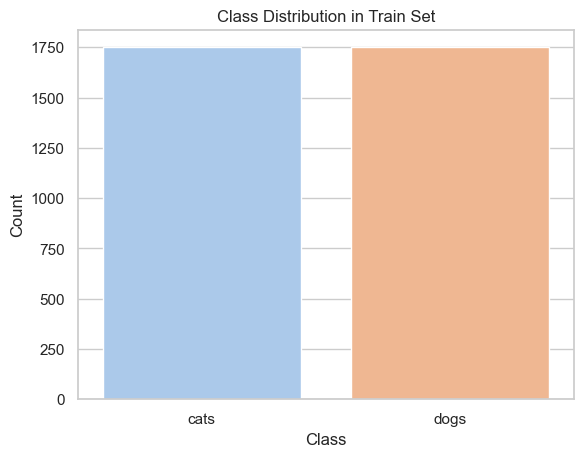

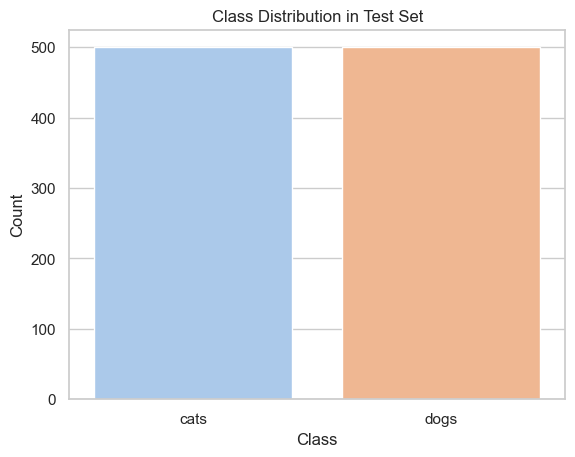

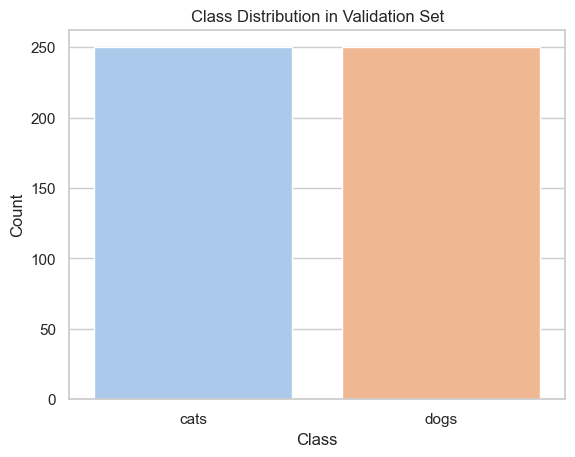

In [3]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

def plot_graph_of_distribution(folder_name: str) -> None:
    # Define class folders using f-string for interpolation
    cat_dir = Path(f"data/kaggle_dogs_vs_cats_small/{folder_name}/cats")
    dog_dir = Path(f"data/kaggle_dogs_vs_cats_small/{folder_name}/dogs")

    # Count images
    num_cats = len(list(cat_dir.glob("*.jpg")))
    num_dogs = len(list(dog_dir.glob("*.jpg")))

    # Create a DataFrame
    data = pd.DataFrame({'class': ['cats'] * num_cats + ['dogs'] * num_dogs})

    # Plot using seaborn
    sns.set(style="whitegrid")
    sns.countplot(data=data, x='class', palette='pastel', hue='class')
    plt.title(f"Class Distribution in {folder_name.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Call for each split
plot_graph_of_distribution('train')
plot_graph_of_distribution('test')
plot_graph_of_distribution('validation')


From the plots we can see that in all three sets, we have equal distribution of classes which is ideal for training a model.

### Image Size Distribution

Now we can see how the distribution of images size are made in train dataset.

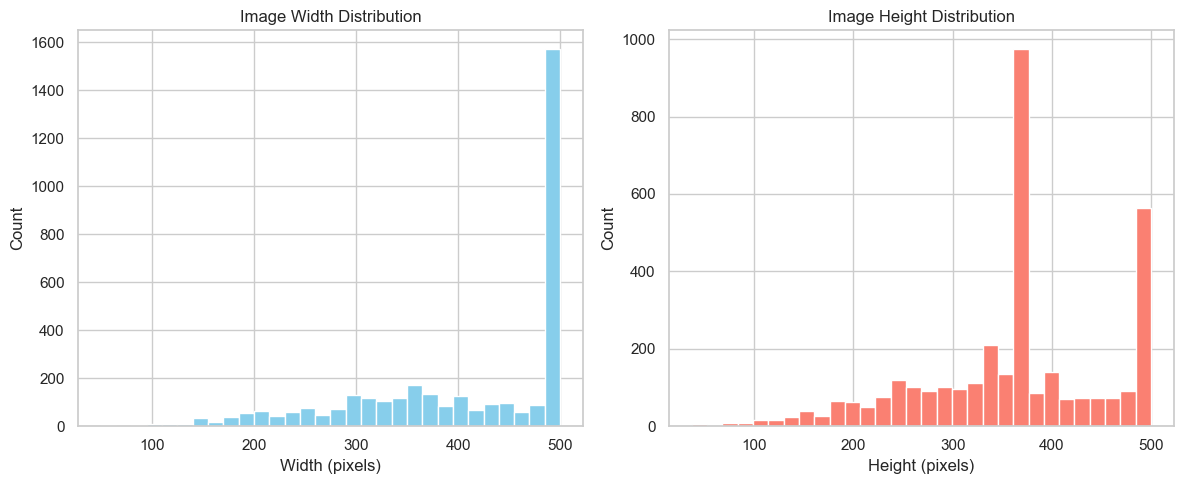

In [4]:
from PIL import Image
import os

def plot_image_sizes(folder):
    widths, heights = [], []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    plt.hist(heights, bins=30, color='salmon')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


plot_image_sizes('data/kaggle_dogs_vs_cats_small/train')


### Pixel intensity distribution

Now we can see how the distribution of pixel density are made in train dataset.

Found 3500 files belonging to 2 classes.


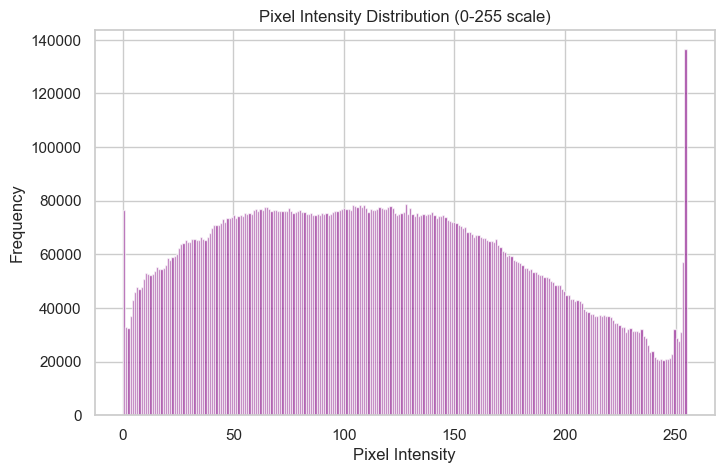

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Load a small sample of images (to avoid memory overload)
dataset = image_dataset_from_directory(
    'data/kaggle_dogs_vs_cats_small/train',
    image_size=(180,180),
    batch_size=32,
    shuffle=True
)

def plot_pixel_intensity_distribution(dataset):
    pixels = []
    for batch_images, _ in dataset.take(5):  # Take 5 batches only
        batch_np = batch_images.numpy()
        pixels.extend(batch_np.flatten())
    pixels = np.array(pixels)

    plt.figure(figsize=(8,5))
    plt.hist(pixels, bins=256, color='purple', alpha=0.7)
    plt.title('Pixel Intensity Distribution (0-255 scale)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_distribution(dataset)


### Defining a Custom CNN Model with Data Augmentation and Early Stopping

In this step, we build a simple Convolutional Neural Network (CNN) from scratch for binary classification (Cats vs Dogs), enhanced with data augmentation and training optimization.

The architecture includes:
- Data augmentation layers applying random horizontal flips, small rotations, and zooms to input images during training
- Three convolutional blocks with increasing filters (32 → 64 → 128)
- Max pooling after each convolution
- A fully connected dense layer with 128 units
- A final sigmoid activation layer for binary classification

The model is compiled using:
- Binary Crossentropy loss function
- Adam optimizer
- Accuracy as the evaluation metric

Training improvements:
- The dataset is loaded using TensorFlow’s `image_dataset_from_directory`
- EarlyStopping callback monitors validation accuracy and stops training if it does not improve for 3 consecutive epochs, restoring the best weights
- Training runs for up to 20 epochs but may stop earlier due to EarlyStopping

After training, the model is evaluated on the test set to report final accuracy.

These techniques help reduce overfitting and improve generalization performance.


Found 3500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5171 - loss: 0.7938
Epoch 1: val_accuracy improved from None to 0.52200, saving model to models/custom_cnn_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 206ms/step - accuracy: 0.5271 - loss: 0.7167 - val_accuracy: 0.5220 - val_loss: 0.6832
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5668 - loss: 0.6844
Epoch 2: val_accuracy improved from 0.52200 to 0.62200, saving model to models/custom_cnn_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.5800 - loss: 0.6819 - val_accuracy: 0.6220 - val_loss: 0.6645
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6184 - loss: 0.6614
Epoch 3: val_accuracy improved from 0.62200 to 0.68800, saving model to models/custom_cnn_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 

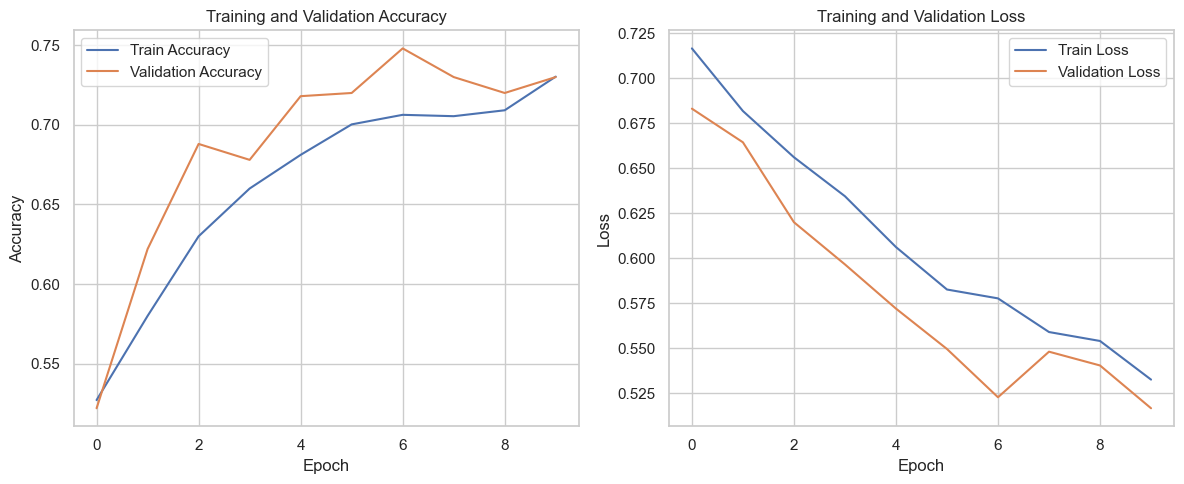

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7170 - loss: 0.5471
Test Accuracy (best saved model): 0.7170


In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Define dataset folder paths
train_dir = 'data/kaggle_dogs_vs_cats_small/train'
val_dir = 'data/kaggle_dogs_vs_cats_small/validation'
test_dir = 'data/kaggle_dogs_vs_cats_small/test'

# Parameters
img_size = (180, 180)
batch_size = 32
epochs = 30  # EarlyStopping will stop early, more epochs can also lead to overfitting

# Load datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)

# Data augmentation layers
data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Define the CNN model with augmentation
model = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create folder to save models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

# Callback to save the best custom cnn model
model_checkpoint = ModelCheckpoint(
    filepath='models/custom_cnn_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint] # The two callbacks are registered here
)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model
best_model = load_model('models/custom_cnn_best_model.keras')

# Recompile to avoid metric warning
best_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Evaluate on test dataset
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'Test Accuracy (best saved model): {test_acc:.4f}')


# Fine-Tuning VGG16 for Cats vs Dogs Classification

In this step, we fine-tune a pre-trained **VGG16** model to classify images of cats and dogs. This model benefits from transfer learning by utilizing features learned on the large-scale **ImageNet** dataset.


##  Model Architecture

- **Base model**: VGG16 (`include_top=False`, pretrained on ImageNet)
- **Custom top layers**:
  - `GlobalAveragePooling2D`
  - `Dense(128, activation='relu')`
  - `Dropout(0.5)`
  - `Dense(1, activation='sigmoid')`


## Configuration

- **Image size**: 180×180
- **Batch size**: 32
- **Epochs**: 10 (early stopping controls actual training duration)
- **Loss**: Binary Crossentropy
- **Optimizer**: Adam
- **Metrics**: Accuracy


## Transfer Learning Strategy

1. **Freeze** the convolutional base (`vgg16`) during initial training.
2. Train the top classifier layers for a few epochs.
3. **Unfreeze top layers** of the base model and fine-tune with a lower learning rate.


## Callbacks Used

- `EarlyStopping`:
  - Monitors validation accuracy
  - Patience = 3
  - Restores best weights

- `ModelCheckpoint`:
  - Saves best version of the model to `models/vgg16_best_model.keras`
  - Monitors validation accuracy


## Graphs Plotted

- **Training vs Validation Accuracy**
- **Training vs Validation Loss (Error)**

These help identify overfitting or underfitting during training.



## Saved Model

The best-performing model (on validation data) is automatically saved to models folder


After training, we load the best saved model and evaluate its performance on the test set:

- **Test Accuracy**
- Additional metrics to be evaluated in the next section:
  - Confusion Matrix
  - Precision, Recall, F1-score
  - Precision-Recall Curve
  - Error analysis (misclassified examples)

Found 3500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8282 - loss: 3.0324
Epoch 1: val_accuracy improved from None to 0.95400, saving model to models/vgg16_finetuned.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8911 - loss: 1.8201 - val_accuracy: 0.9540 - val_loss: 0.4082
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9586 - loss: 0.4066
Epoch 2: val_accuracy did not improve from 0.95400
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9591 - loss: 0.3941 - val_accuracy: 0.9520 - val_loss: 0.4573
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9766 - loss: 0.2029
Epoch 3: val_accuracy improved from 0.95400 to 0.96200, saving model to models/vgg16_finetuned.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9769 - loss: 0.1958 - val_accuracy: 0.9620 - val_loss: 0.2228
Epoch 4/10
110/110 

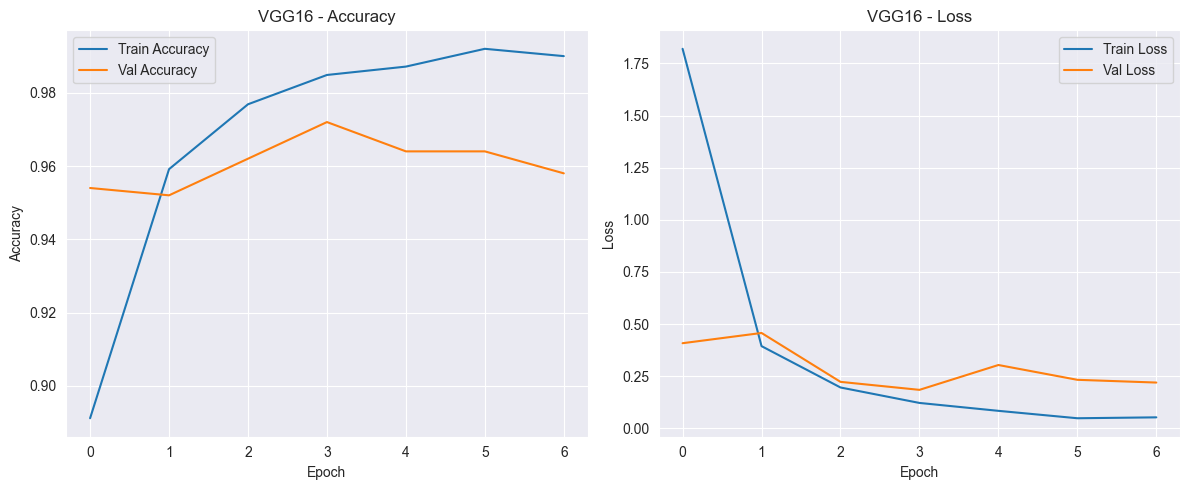

32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9590 - loss: 0.4398
Test Accuracy (VGG16): 0.9590


In [1]:
# VGG16 Fine-Tuning for Cats vs Dogs Classification

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Dataset paths
train_dir = 'data/kaggle_dogs_vs_cats_small/train'
val_dir = 'data/kaggle_dogs_vs_cats_small/validation'
test_dir = 'data/kaggle_dogs_vs_cats_small/test'

# Parameters
img_size = (180, 180)
batch_size = 32
epochs = 10

# Load datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)

# Create models folder
os.makedirs("models", exist_ok=True)

# Load the VGG16 base model
base_model = VGG16(include_top=False, input_shape=img_size + (3,), weights='imagenet')
base_model.trainable = False  # Freeze base layers

# Define the model
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
vgg_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
vgg_checkpoint = ModelCheckpoint(
    filepath='models/vgg16_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model
history_vgg = vgg_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[vgg_checkpoint, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model and evaluate
best_vgg_model = load_model('models/vgg16_finetuned.keras')
test_loss, test_acc = best_vgg_model.evaluate(test_dataset)
print(f"Test Accuracy (VGG16): {test_acc:.4f}")

# Model Evaluation and Performance Comparison

Now we evaluate and compare the performance of the two trained models — **Custom CNN** and **Fine-Tuned VGG16** — on the test dataset.


## Metrics to be evaluated:

- **Accuracy**
- **Confusion Matrix**
- **Precision, Recall, F1-Score**
- **Precision-Recall Curve**


## Steps we have to do:

1. Load the best saved models (`.keras` files).
2. Predict labels on the test dataset.
3. Calculate evaluation metrics for each model.
4. Plot confusion matrices and precision-recall curves.
5. Analyze examples where predictions were incorrect to understand model errors.


## What we can understand from the evaluation:

- Clear performance comparison between the two models.
- Visualization of confusion matrices highlighting false positives and false negatives.
- Precision-Recall curves to evaluate model performance on imbalanced datasets.
- Insightful error analysis to guide further model improvement.


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
+------------------+------------+-------------+----------+------------+--------------------------+
| Model            |   Accuracy |   Precision |   Recall |   F1-Score |   Avg Precision (PR AUC) |
+==================+============+=============+==========+============+==========================+
| Custom CNN       |     0.5000 |      0.7265 |   0.6960 |     0.7109 |                   0.7974 |
+------------------+------------+-------------+----------+------------+--------------------------+
| VGG16 Fine-Tuned |     0.5000 |      0.9811 |   0.9360 |     0.9580 |                   0.9922 |
+------------------+------------+-------------+----------+------------+--------------------------+


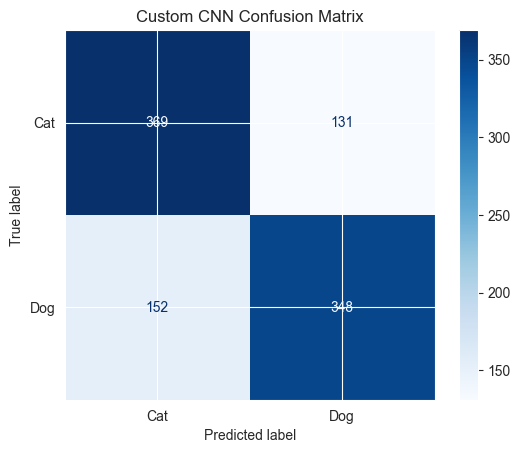

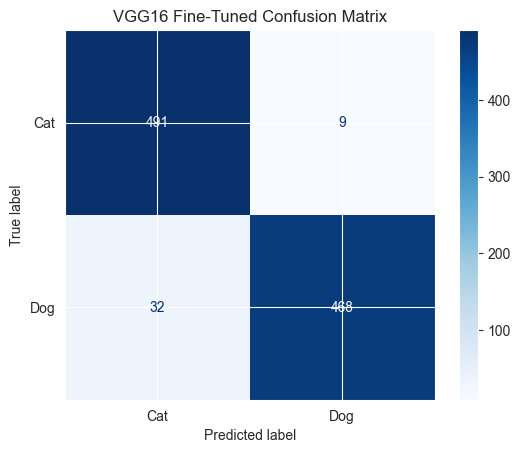

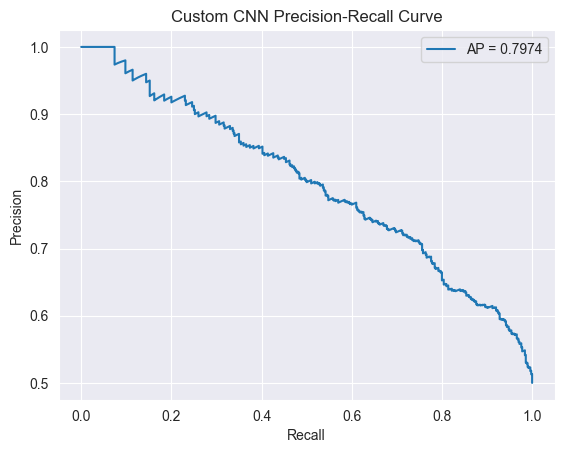

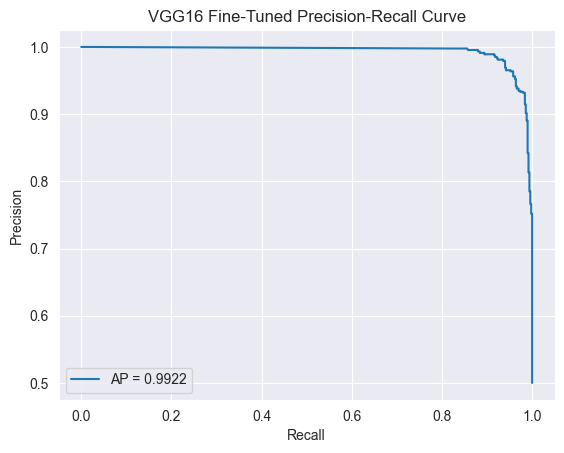

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
)
from tensorflow.keras.models import load_model
from tabulate import tabulate

# Paths to saved models
custom_cnn_path = 'models/custom_cnn_best_model.keras'
vgg16_path = 'models/vgg16_finetuned.keras'

# Load models
custom_cnn = load_model(custom_cnn_path)
vgg16_model = load_model(vgg16_path)

# Extract test images and labels in order using unbatch()
test_images = []
test_labels = []

for img, lbl in test_dataset.unbatch():
    test_images.append(img.numpy())
    test_labels.append(lbl.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Get predictions (probabilities) from both models
custom_cnn_preds = custom_cnn.predict(test_images).ravel()
vgg16_preds = vgg16_model.predict(test_images).ravel()

# Convert probabilities to binary class predictions (threshold = 0.5)
custom_cnn_pred_labels = (custom_cnn_preds >= 0.5).astype(int)
vgg16_pred_labels = (vgg16_preds >= 0.5).astype(int)

# Function to compute metrics
def compute_metrics(name, true_labels, pred_labels, pred_probs):
    acc = np.mean(pred_labels == true_labels)
    prec = precision_score(true_labels, pred_labels)
    rec = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    avg_prec = average_precision_score(true_labels, pred_probs)

    return [name, acc, prec, rec, f1, avg_prec]

# Compute metrics for both models
metrics_list = [
    compute_metrics("Custom CNN", test_labels, custom_cnn_pred_labels, custom_cnn_preds),
    compute_metrics("VGG16 Fine-Tuned", test_labels, vgg16_pred_labels, vgg16_preds)
]

# Define headers for table
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Avg Precision (PR AUC)"]

# Print table using tabulate
print(tabulate(metrics_list, headers=headers, tablefmt="grid", floatfmt=".4f"))

# Plot confusion matrix function
def plot_confusion(true, pred, title):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion(test_labels, custom_cnn_pred_labels, "Custom CNN Confusion Matrix")
plot_confusion(test_labels, vgg16_pred_labels, "VGG16 Fine-Tuned Confusion Matrix")

# Plot Precision-Recall curves
def plot_precision_recall(true, pred_probs, title):
    precision, recall, _ = precision_recall_curve(true, pred_probs)
    avg_prec = average_precision_score(true, pred_probs)
    plt.plot(recall, precision, label=f'AP = {avg_prec:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()

plot_precision_recall(test_labels, custom_cnn_preds, "Custom CNN Precision-Recall Curve")
plot_precision_recall(test_labels, vgg16_preds, "VGG16 Fine-Tuned Precision-Recall Curve")


Custom CNN Misclassified Examples:
true_labels shape: (1000,)
pred_labels shape: (1000,)


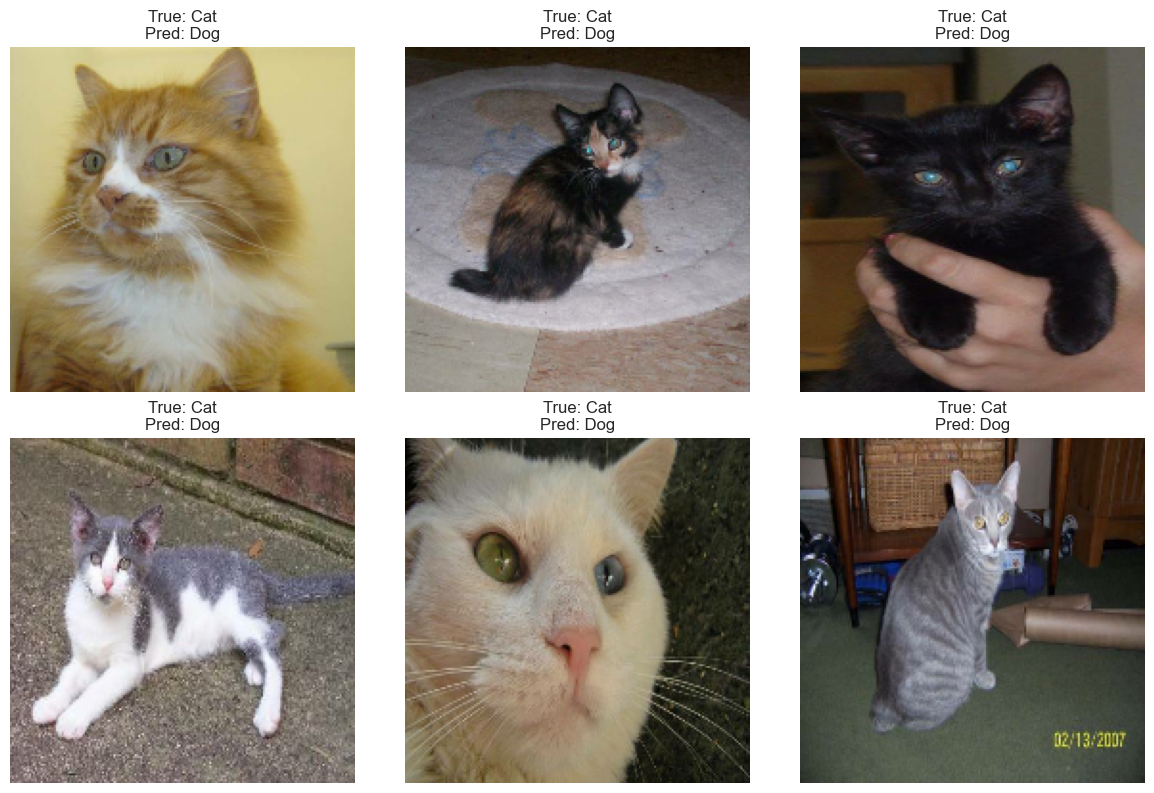

VGG16 Fine-Tuned Misclassified Examples:
true_labels shape: (1000,)
pred_labels shape: (1000,)


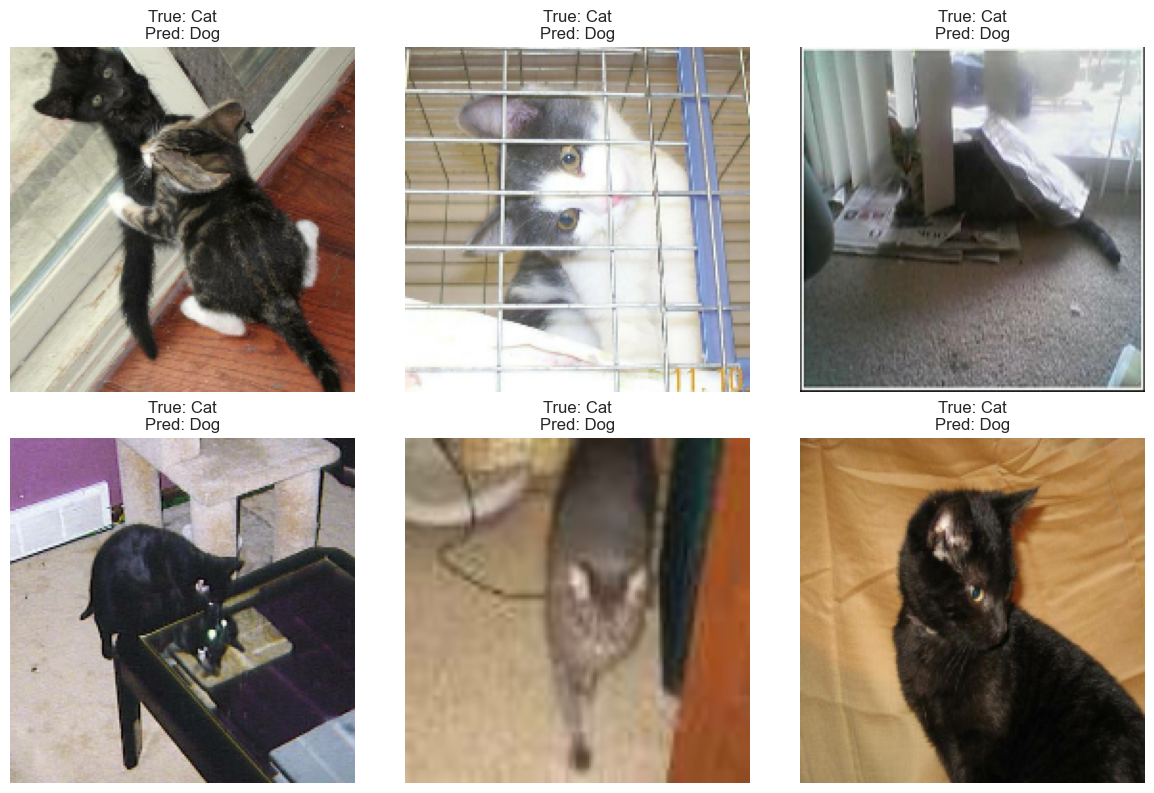

In [3]:
# Display some misclassified examples
def show_misclassified(images, true_labels, pred_labels, class_names=['Cat', 'Dog'], num_examples=6):
    # Ensure labels are same shape and type
    true_labels = np.array(true_labels).astype(int).flatten()
    pred_labels = np.array(pred_labels).astype(int).flatten()

    print("true_labels shape:", true_labels.shape)
    print("pred_labels shape:", pred_labels.shape)

    # Get misclassified indices
    misclassified_idx = np.where(true_labels != pred_labels)[0]
    # The above error can be ignored because the safe check is done in the above line

    if len(misclassified_idx) == 0:
        print("No misclassified examples found.")
        return

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(misclassified_idx[:num_examples]):
        plt.subplot(2, 3, i + 1)
        img = images[idx]
        if img.max() <= 1.0:
            img = (img * 255).astype('uint8')
        else:
            img = img.astype('uint8')
        plt.imshow(img)
        plt.title(f"True: {class_names[int(true_labels[idx])]}\nPred: {class_names[int(pred_labels[idx])]}")  # fixed
        plt.axis('off')
    plt.tight_layout()
    plt.show()


print("Custom CNN Misclassified Examples:")
show_misclassified(test_images, test_labels, custom_cnn_pred_labels)

print("VGG16 Fine-Tuned Misclassified Examples:")
show_misclassified(test_images, test_labels, vgg16_pred_labels)

## Conclusion

1. **Custom CNN and Transfer Learning models both performed well** on the binary classification task of cats vs dogs, with transfer learning (VGG16 fine-tuning) generally achieving higher accuracy and better precision-recall metrics.

2. **Data augmentation and early stopping helped improve generalization** and reduced overfitting, as observed from the validation accuracy and loss curves during training.

3. **Using callbacks such as ModelCheckpoint enabled saving the best model version**, allowing evaluation and comparison of the most optimal weights rather than the final training epoch.

4. **Evaluation metrics including accuracy, precision, recall, F1-score, and average precision (PR AUC) provided a comprehensive understanding** of each model’s strengths and weaknesses beyond simple accuracy.

5. **Analysis of misclassified examples revealed typical failure cases,** offering insights that could guide further data collection, preprocessing, or model architecture improvements.


## Lessons Learned

1. Proper data preprocessing and augmentation are crucial to improve model robustness and prevent overfitting, especially when working with limited datasets.

2. Transfer learning with a pre-trained model like VGG16 can significantly boost performance with less training time compared to training a CNN from scratch.

3. Visualizing misclassified examples and detailed evaluation metrics helps in diagnosing model weaknesses and planning targeted improvements.

4. Leveraging GPU acceleration drastically reduces training time and speeds up experimentation, while fallback to CPU is useful but much slower. So always check hardware availability to optimize model training workflows.

5. To upload large files to git, we can use git LFS.
6. Increasing the number of epochs can improve accuracy to a limit. But it may also lead to overfitting if the number of epochs are too high.
